In [1]:
import pandas as pd
import numpy as np
import nltk
import string
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords,wordnet
from nltk.tokenize import word_tokenize
from textblob import TextBlob
from datetime import datetime
import pytz
import seaborn as sns
from pandas_profiling import ProfileReport
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.model_selection import train_test_split,cross_val_score, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
import statsmodels.api as sm
from scipy import stats
from keras.models import Sequential
from keras.layers import Dense
import scikeras
from scikeras.wrappers import KerasRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel

2022-02-25 04:03:32.803905: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-25 04:03:32.803948: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Data Aquisation
Due to source data issue, bad lines are skipped (as we had a large data set)

In [2]:
cdf_data = pd.read_csv('cdf_train.csv',on_bad_lines='skip',encoding= 'unicode_escape')

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (7,19,25,26,127) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
cdf_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305405 entries, 0 to 305404
Columns: 133 entries, Page.Name to train_test
dtypes: float64(105), int64(1), object(27)
memory usage: 309.9+ MB


In [4]:
cdf_data.describe()

,Facebook.Id,Followers.at.Posting,Total.Interactions,Likes,Comments,Shares,Love,Wow,Sad,Angry,...,Period,Comma,Colon,SemiC,QMark,Exclam,Quote,Apostro,Parenth,OtherP
count,3.054050e+05,2.134310e+05,288688.000000,305404.000000,305404.000000,305404.000000,305404.000000,305403.000000,305404.000000,305404.000000,...,305404.000000,305404.000000,305404.000000,305404.000000,305404.000000,305404.000000,305403.000000,305403.000000,305403.000000,305403.000000
mean,4.718250e+13,1.383248e+06,104.397595,153.017662,52.575209,89.026801,30.580405,10.085205,15.325025,9.088620,...,5.815451,2.845213,1.313080,0.028095,0.517059,1.099687,0.596462,2.028299,0.373102,3.726192
std,1.555918e+14,2.837662e+06,176.524703,3330.231562,936.817725,2745.924834,1487.202899,135.341036,260.749970,136.465705,...,3.840582,3.329149,2.250954,0.281566,1.390970,2.407347,1.884042,2.872608,1.498601,6.780763
min,8.510940e+05,1.670000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.025263e+10,1.775770e+05,8.000000,5.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,3.450000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.261918e+11,4.035280e+05,28.000000,16.000000,3.000000,4.000000,1.000000,0.000000,0.000000,0.000000,...,5.330000,2.130000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3.430353e+11,6.967820e+05,111.000000,57.000000,19.000000,18.000000,4.000000,2.000000,1.000000,0.000000,...,7.760000,4.350000,2.220000,0.000000,0.000000,1.490000,0.000000,3.230000,0.000000,4.920000
max,1.830666e+15,9.789970e+07,999.000000,955621.000000,359253.000000,650858.000000,586138.000000,35361.000000,66906.000000,50265.000000,...,100.000000,51.280000,32.280000,12.310000,83.330000,344.440000,50.000000,40.740000,50.000000,150.000000


In [5]:
cdf_data.isnull().sum()

Page.Name                 0
User.Name                 0
Facebook.Id               0
Page.Category             1
Page.Admin.Top.Country    0
                         ..
Quote                     2
Apostro                   2
Parenth                   2
OtherP                    2
train_test                2
Length: 133, dtype: int64

# Data cleaning

## 1. Clean out records that do not have value at train_test (bad data).

In [6]:
cdf_data.loc[cdf_data.train_test.isnull()]

,Page.Name,User.Name,Facebook.Id,Page.Category,Page.Admin.Top.Country,Page.Description,Page.Created,Likes.at.Posting,Followers.at.Posting,Post.Created,...,Colon,SemiC,QMark,Exclam,Dash,Quote,Apostro,Parenth,OtherP,train_test
6867,OZY,OZY,1393911800825140,MEDIA_NEWS_COMPANY,US,One bourbon,one scotch,one beer: Whatâs considered a standard drink?,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6868,#LiveCuriously,2014-07-18 10:06:50 EDT,851094,NaN,2017-04-27 18:05:00 EDT,2017-04-27,18:05:00,Link,167.0,115,...,0.0,2.04,4.08,2.04,train,NaN,NaN,NaN,NaN,NaN


In [7]:
cdf_data = cdf_data.loc[~cdf_data.train_test.isnull()]

## 2. Check each column data type

In [8]:
pd.DataFrame(cdf_data.dtypes).to_csv('data_type_list.csv')

We can use this list to find out irregular data types.

In [9]:
cdf_data.iloc[:,:20].dtypes

Page.Name                  object
User.Name                  object
Facebook.Id                 int64
Page.Category              object
Page.Admin.Top.Country     object
Page.Description           object
Page.Created               object
Likes.at.Posting           object
Followers.at.Posting      float64
Post.Created               object
Post.Created.Date          object
Post.Created.Time          object
Type                       object
Total.Interactions        float64
Likes                     float64
Comments                  float64
Shares                    float64
Love                      float64
Wow                       float64
Haha                       object
dtype: object

In [10]:
cdf_data.iloc[:,20:40].dtypes

Sad                               float64
Angry                             float64
Care                              float64
Video.Share.Status                 object
Is.Video.Owner.                    object
Post.Views                         object
Total.Views                        object
Total.Views.For.All.Crossposts    float64
Video.Length                      float64
URL                                object
Message                            object
Link                               object
Final.Link                         object
Image.Text                         object
Link.Text                          object
Description                        object
Sponsor.Id                        float64
Sponsor.Name                       object
Sponsor.Category                   object
WC                                float64
dtype: object

### Transform Facebook ID into string.

In [11]:
cdf_data.loc[:,'Facebook.Id'] = cdf_data['Facebook.Id'].astype('object')

### Check Followers data type.

In [12]:
cdf_data['Followers.at.Posting']

0                NaN
1                NaN
2                NaN
3                NaN
4                NaN
             ...    
305400      945035.0
305401      348282.0
305402      375241.0
305403    14458452.0
305404      810517.0
Name: Followers.at.Posting, Length: 305403, dtype: float64

Make sense as Pandas doesn't handel null values well with integer.

### Check timestamp related columns

In [13]:
cdf_data['Post.Created']

0         2016-06-01 20:45:00 EDT
1         2016-06-01 18:23:07 EDT
2         2016-06-01 17:33:00 EDT
3         2016-06-01 17:15:39 EDT
4         2016-06-01 14:00:00 EDT
                   ...           
305400    2020-12-26 02:15:11 EST
305401    2020-12-26 02:15:02 EST
305402    2020-12-26 02:11:21 EST
305403    2020-12-26 02:09:56 EST
305404    2020-12-26 02:03:58 EST
Name: Post.Created, Length: 305403, dtype: object

***Note that time zone is irregular. We need to read in and standardize time zone information***

In [14]:
np.unique(cdf_data['Post.Created'].str[-3:])

array(['EDT', 'EST'], dtype=object)

We are dealing with US Eastern time in different format.

In [15]:
def convert_ts(dt_str):
    ts = dt_str[:-4]
    fmt = "%Y-%m-%d %H:%M:%S"
    read_in_dt = datetime.strptime(ts,fmt)
    local_tz = pytz.timezone('US/Eastern')
    date_local = local_tz.localize(read_in_dt)
    return date_local

In [16]:
trans_ts = lambda x: convert_ts(x)

In [17]:
cdf_data.loc[:,'Post.Created'] = cdf_data['Post.Created'].apply(trans_ts)

In [18]:
cdf_data.loc[:,'Page.Created'] = cdf_data['Page.Created'].apply(trans_ts)

Drop duplicated information.

In [19]:
cdf_data = cdf_data.drop(['Post.Created.Date','Post.Created.Time'], axis = 1)

### Check Type

In [20]:
np.unique(cdf_data['Type'])

array(['Link', 'Live Video', 'Live Video Complete',
       'Live Video Scheduled', 'Native Video', 'Photo', 'Status', 'Video',
       'YouTube'], dtype=object)

### Check Interations
Interactions is the total number of interactions (like, share etc.). The default behavior is that all of these are simply added together.

In [21]:
cdf_data.loc[cdf_data['Total.Interactions'].isnull(),].iloc[:,10:25]

,Type,Total.Interactions,Likes,Comments,Shares,Love,Wow,Haha,Sad,Angry,Care,Video.Share.Status,Is.Video.Owner.,Post.Views,Total.Views
9,Native Video,NaN,922.0,57.0,593.0,23.0,1.0,0,0.0,1.0,0.0,owned,Yes,0,160065
13,Native Video,NaN,1864.0,145.0,1366.0,55.0,11.0,2,0.0,1.0,0.0,owned,Yes,0,249706
14,Native Video,NaN,1972.0,292.0,2616.0,87.0,26.0,0,0.0,0.0,0.0,owned,Yes,0,263340
19,Native Video,NaN,987.0,56.0,583.0,41.0,14.0,2,1.0,0.0,0.0,crosspost,Yes,0,100209
22,Native Video,NaN,2773.0,481.0,1888.0,121.0,33.0,2,0.0,0.0,0.0,crosspost,Yes,0,337525
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305351,Link,NaN,1115.0,1393.0,289.0,37.0,148.0,205,589.0,55.0,29.0,NaN,-,0,0
305354,Video,NaN,136.0,675.0,92.0,3.0,23.0,13,531.0,201.0,9.0,NaN,-,0,0
305372,Link,NaN,1778.0,1044.0,405.0,35.0,79.0,789,179.0,34.0,23.0,NaN,-,0,0
305387,Link,NaN,522.0,105.0,54.0,2.0,67.0,13,241.0,2.0,13.0,NaN,-,0,0


Check definition of interations.

In [22]:
subset_notnull_cdf = cdf_data.loc[~cdf_data['Total.Interactions'].isnull(),:]

In [23]:
subset_notnull_cdf['Total.Interactions'] = subset_notnull_cdf['Total.Interactions'].fillna(0).astype(int)
subset_notnull_cdf[['Likes','Comments','Shares','Love','Wow','Haha','Sad','Angry','Care']] = subset_notnull_cdf[['Likes','Comments','Shares','Love','Wow','Haha','Sad','Angry','Care']].fillna(0).astype(int)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [24]:
c = np.where(subset_notnull_cdf[['Likes','Comments','Shares','Love','Wow','Haha','Sad','Angry','Care']]
      .sum(axis=1) == subset_notnull_cdf['Total.Interactions'], 0, 1)

In [25]:
c.sum()

0

With current data set, we can constract values to fill in NAs in this column.

In [26]:
cdf_data['Total.Interactions'] = cdf_data['Total.Interactions'].fillna(cdf_data[['Likes','Comments','Shares','Love','Wow','Haha','Sad','Angry','Care']].sum(axis=1))


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


### Views and cross post views

In [27]:
cdf_data.loc[:,'Post.Views'] = pd.to_numeric(cdf_data['Post.Views'])

In [28]:
cdf_data.loc[:,'Total.Views'] = pd.to_numeric(cdf_data['Total.Views'])

### Sponsor ID

In [29]:
cdf_data.loc[:,'Sponsor.Id'] = cdf_data['Sponsor.Id'].astype('str')

### Dash

In [30]:
cdf_data.loc[:,'Dash'] = cdf_data['Dash'].astype('float')

### Likes at posting

In [31]:
cdf_data['Likes.at.Posting'] = cdf_data['Likes.at.Posting'].astype('int64')

### Reaction: Haha

In [32]:
cdf_data['Haha'] = cdf_data['Haha'].astype('int64')

### Video.Length

In [33]:
cdf_data.loc[~cdf_data['Video.Length'].isnull(),:]

,Page.Name,User.Name,Facebook.Id,Page.Category,Page.Admin.Top.Country,Page.Description,Page.Created,Likes.at.Posting,Followers.at.Posting,Post.Created,...,Colon,SemiC,QMark,Exclam,Dash,Quote,Apostro,Parenth,OtherP,train_test


Consider dropping Video.Length

## Drop unary column and IDs

In [34]:
cdf_data = cdf_data.drop(['Page.Admin.Top.Country', 'Facebook.Id', 'Video.Length','Sponsor.Id','train_test'], axis=1)

In [35]:
cdf_data.dtypes

Page.Name                               object
User.Name                               object
Page.Category                           object
Page.Description                        object
Page.Created        datetime64[ns, US/Eastern]
                               ...            
Dash                                   float64
Quote                                  float64
Apostro                                float64
Parenth                                float64
OtherP                                 float64
Length: 126, dtype: object

## Datetime encoding

### Days since page created

In [36]:
benchmark_timezone = pytz.timezone('US/Eastern')
benchmark_date = datetime.strptime('2021-02-20','%Y-%m-%d')
benchmark_date_local = benchmark_timezone.localize(benchmark_date)
cdf_data['PageSinceCreated'] =  (benchmark_date_local - cdf_data['Page.Created']).dt.days

### Datetime encoding - extract year, month, day and hour

In [37]:
cdf_data['PageCreatedYear'] = pd.DatetimeIndex(cdf_data['Page.Created']).year
cdf_data['PageCreatedMonth'] = pd.DatetimeIndex(cdf_data['Page.Created']).month
cdf_data['PageCreatedDay'] = pd.DatetimeIndex(cdf_data['Page.Created']).weekday
cdf_data['PageCreatedHour'] = pd.DatetimeIndex(cdf_data['Page.Created']).hour

In [38]:
cdf_data['PostCreatedYear'] = pd.DatetimeIndex(cdf_data['Post.Created']).year
cdf_data['PostCreatedMonth'] = pd.DatetimeIndex(cdf_data['Post.Created']).month
cdf_data['PostCreatedday'] = pd.DatetimeIndex(cdf_data['Post.Created']).weekday
cdf_data['PostCreatedHour'] = pd.DatetimeIndex(cdf_data['Post.Created']).hour

In [39]:
#cdf_data = cdf_data.drop(['Post.Created','Page.Created'], axis=1)

## Drop duplicates data records

In [40]:
cdf_data = cdf_data.drop_duplicates()

## Data profiling 

In [41]:
profile = ProfileReport(cdf_data, title="Pandas Profiling Report", correlations=None, interactions={'continuous': False}, explorative=False)
profile.to_file(output_file="data_report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:1442: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  return df.reset_index(level=level, drop=drop)


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## Check point: full clean data

In [42]:
cdf_data.to_csv('clean_cdf_data_full.csv',index = False)

In [43]:
cdf_data.shape

(212787, 135)

In [ ]:
cdf_data_clean = cdf_data

# Preprocessing

In [3]:
cdf_data_clean = pd.read_csv('clean_cdf_data_full.csv')

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (31,32) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [103]:
pd.DataFrame(cdf_data_clean.dtypes).to_csv('clean_data_type_list.csv')

## Fill in null values: Followers.at.Posting

<AxesSubplot:xlabel='Post.Created'>

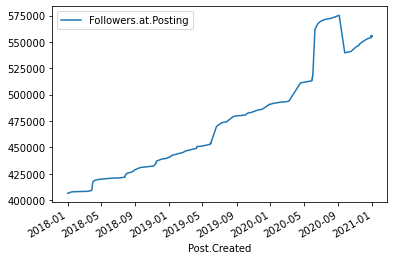

In [104]:
%matplotlib inline
ABC10_data = cdf_data_clean.loc[cdf_data_clean['Page.Name']=='ABC10',['Followers.at.Posting','Post.Created']]
ABC10_data['Post.Created'] = pd.to_datetime(ABC10_data['Post.Created'])
#ABC10_data['Post.Created'] = pd.DatetimeIndex(ABC10_data['Post.Created'])
ABC10_data = ABC10_data.set_index('Post.Created')
ABC10_data.plot()

For each page, we estimate the number of followers using a linear regression based on time series (time when the post was posted)

### Imputation: Linear Regression

In [4]:
cdf_data_clean['Post.Created'] = pd.to_datetime(cdf_data_clean['Post.Created'])

In [5]:
def imput_followers_at_posting(data):
    pages = np.unique(data['Page.Name'])
    df = pd.DataFrame(columns = data.columns)
    for page in pages:
        #print("Proceeding page:",page)
        page_data = data[data['Page.Name']==page].sort_values(by='Post.Created')
        x = np.arange(page_data['Post.Created'].size)
        page_data['x'] = x
        na_page = page_data[page_data['Followers.at.Posting'].isnull()==True]
        non_na_page = page_data[page_data['Followers.at.Posting'].isnull()==False]
        if na_page.shape[0] > 0:
            if non_na_page.shape[0] > 0:
                fit = np.polyfit(non_na_page['x'], non_na_page['Followers.at.Posting'], deg=1)
                fit_function = np.poly1d(fit)
                prediction = fit_function(na_page['x'])
                imputed = np.where(prediction<0,0,prediction)
                #print(prediction)
                na_page['Followers.at.Posting'] = imputed
                proceeded_data = pd.concat([non_na_page,na_page]).drop('x', axis=1)
            else:
                # page was too old, impute from median followers in the same year(s)
                years = np.unique(na_page['PostCreatedYear'])
                year_median = data[data['PostCreatedYear'].isin(years)]['Followers.at.Posting'].median()
                na_page['Followers.at.Posting'] = year_median
                if na_page['Followers.at.Posting'].isnull().sum()>0:
                    na_page['Followers.at.Posting'] = data['Followers.at.Posting'].median()
                proceeded_data = na_page
        else:
            proceeded_data = non_na_page
        page_data = page_data.drop('x', axis=1)
        df = pd.concat([df,proceeded_data])
    return df

In [6]:
imputed_cdf_data = imput_followers_at_posting(cdf_data_clean)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of

<AxesSubplot:xlabel='Followers.at.Posting', ylabel='Count'>

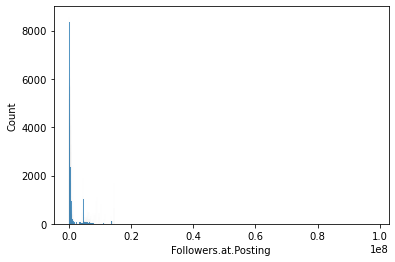

In [11]:
%matplotlib inline
sns.histplot(data = imputed_cdf_data,x='Followers.at.Posting')

## Transform message column

In [109]:
imputed_cdf_data['Message'].isnull().sum()

4357

### Remove stopwords, tokenized and lemmatization

In [12]:
def process_description(text):
    if not pd.isnull(text):
        # tokenize 
        tags = nltk.pos_tag(word_tokenize(text))
        #Import the english stop words list from NLTK
        stopwords_english = stopwords.words('english') 

        #Creating a list of words without stopwords
        pos_dict = {'J':wordnet.ADJ, 'V':wordnet.VERB, 'N':wordnet.NOUN, 'R':wordnet.ADV}
        desc_clean = []
        for word, tag in tags:
            if word not in stopwords_english and word not in string.punctuation:
                desc_clean.append(tuple([word.lower(), pos_dict.get(tag[0])]))

        #Instantiate stemming class
        lemmatizer = WordNetLemmatizer()

        #Creating a list of stems of words 
        lemma_desc = ""
        for clean_word, pos in desc_clean:
            if not pos:
                lemma = clean_word
                lemma_desc = lemma_desc + " " + lemma
            else:
                lemma = lemmatizer.lemmatize(clean_word, pos=pos)
                lemma_desc = lemma_desc + " " + lemma
    else:
        lemma_desc = ''
    return lemma_desc

In [13]:
imputed_cdf_data['Message_lemma'] = imputed_cdf_data['Message'].apply(process_description)

### Sentiment and subjective score

In [14]:
def datablob(lemma):
    return TextBlob(lemma).sentiment

In [15]:
imputed_cdf_data['Message_senti'] = imputed_cdf_data['Message_lemma'].apply(datablob)

In [16]:
imputed_cdf_data['Message_sentiment'] = imputed_cdf_data['Message_senti'].str[0]
imputed_cdf_data['Message_subjective'] = imputed_cdf_data['Message_senti'].str[1]
imputed_cdf_data['Message_len'] =  imputed_cdf_data['Message'].str.len().fillna(0)

In [17]:
imputed_cdf_data['Message_sentiment_category'] = np.where(imputed_cdf_data['Message_sentiment']>0,'Positive','Negative')
imputed_cdf_data['Message_subjective_category'] = np.where(imputed_cdf_data['Message_subjective']>0.5,'Subjective','Objective')

In [18]:
imputed_cdf_data = imputed_cdf_data.drop(['Message','Message_lemma','Message_senti'],axis=1)

## Drop url columns

In [19]:
imputed_cdf_data['is_linked'] = np.where(pd.isnull(imputed_cdf_data['Link']),0,1).astype('str')

In [20]:
imputed_cdf_data = imputed_cdf_data.drop(['URL','Link','Final.Link'],axis=1)

## Image Text

In [21]:
imputed_cdf_data['image_text_ind'] = np.where(pd.isnull(imputed_cdf_data['Image.Text']),0,1).astype('str')

In [22]:
imputed_cdf_data = imputed_cdf_data.drop(['Image.Text'],axis=1)

## Headline of a link URL or the title of a native video

In [23]:
imputed_cdf_data['link_title_len'] =  imputed_cdf_data['Link.Text'].str.len().fillna(0)

In [24]:
imputed_cdf_data = imputed_cdf_data.drop(['Link.Text'],axis=1)

## Description: the sub-header of a link URL

In [25]:
imputed_cdf_data['Description'] = imputed_cdf_data['Description'].str.replace('-','')
imputed_cdf_data['link_desp_len'] =  imputed_cdf_data['Description'].str.len().fillna(0)

In [26]:
imputed_cdf_data = imputed_cdf_data.drop(['Description'],axis=1)

## Preprocessing sponsor info

Drop sponsor name for high cardinality

In [69]:
imputed_cdf_data = imputed_cdf_data.drop(['Sponsor.Name'],axis=1)

## Encode

## sponsor category: Target Encoding

In [27]:
imputed_cdf_data['Sponsor.Category'] = imputed_cdf_data['Sponsor.Category'].fillna('Not_Capable')

In [29]:
sponsor_cate_effect_lookup = imputed_cdf_data.groupby('Sponsor.Category')['Total.Interactions'].mean().reset_index().rename(columns={"Total.Interactions":"sponsor_cate_effect"})

In [30]:
imputed_cdf_data = imputed_cdf_data.merge(sponsor_cate_effect_lookup, on = 'Sponsor.Category', how='left')

In [73]:
imputed_cdf_data = imputed_cdf_data.drop('Sponsor.Category',axis=1)

## Page Name vs Use Name

In [74]:
len(np.unique(imputed_cdf_data['Page.Name']))

256

In [75]:
len(np.unique(imputed_cdf_data['User.Name']))

258

Page name and user name are approximately matched. However, due to high cardinality, we are dropping these columns.

In [76]:
imputed_cdf_data = imputed_cdf_data.drop(['User.Name','Page.Name'],axis=1)

### Encode Page Category: Target Encoding

In [77]:
len(np.unique(imputed_cdf_data['Page.Category']))

21

In [31]:
page_cate_effect_lookup = imputed_cdf_data.groupby('Page.Category')['Total.Interactions'].mean().reset_index().rename(columns={"Total.Interactions":"page_cate_effect"})

In [32]:
imputed_cdf_data = imputed_cdf_data.merge(page_cate_effect_lookup, on = 'Page.Category', how='left')

In [80]:
imputed_cdf_data = imputed_cdf_data.drop('Page.Category', axis=1)

## Transform page description into sentiment and subjective

In [34]:
imputed_cdf_data['page_desc_lemma'] = imputed_cdf_data['Page.Description'].apply(process_description)
imputed_cdf_data['page_desc_senti'] = imputed_cdf_data['page_desc_lemma'].apply(datablob)
imputed_cdf_data['page_desc_sentiment'] = imputed_cdf_data['page_desc_senti'].str[0]
imputed_cdf_data['page_desc_subjective'] = imputed_cdf_data['page_desc_senti'].str[1]
imputed_cdf_data['page_desc_len'] =  imputed_cdf_data['Page.Description'].str.len()
imputed_cdf_data['page_desc_sentiment_category'] = np.where(imputed_cdf_data['page_desc_sentiment']>0,'Positive','Negative')
imputed_cdf_data['page_desc_subjective_category'] = np.where(imputed_cdf_data['page_desc_subjective']>0.5,'Subjective','Objective')
imputed_cdf_data = imputed_cdf_data.drop(['Page.Description','page_desc_lemma','page_desc_senti'],axis=1)

## Encode Type

In [35]:
Type_dummified = pd.get_dummies(imputed_cdf_data.Type)
imputed_cdf_data = pd.concat([imputed_cdf_data, Type_dummified], axis=1)

In [83]:
imputed_cdf_data = imputed_cdf_data.drop("Type", axis=1)

## Encode Video share status

In [36]:
share_status_dummified = pd.get_dummies(imputed_cdf_data['Video.Share.Status'])
imputed_cdf_data = pd.concat([imputed_cdf_data, share_status_dummified], axis=1)

In [ ]:
imputed_cdf_data = imputed_cdf_data.drop('Video.Share.Status', axis=1)

## Encode video ownership

In [37]:
video_owner_dummified = pd.get_dummies(imputed_cdf_data['Is.Video.Owner.'])
imputed_cdf_data = pd.concat([imputed_cdf_data, video_owner_dummified], axis=1)

In [ ]:
imputed_cdf_data = imputed_cdf_data.drop('Is.Video.Owner.', axis=1)

In [39]:
cdf_data_model = imputed_cdf_data.drop(['Page.Created','Post.Created','x'],axis=1)

In [40]:
cdf_data_model['Likes.at.Posting']= cdf_data_model['Likes.at.Posting'].astype('int')

In [41]:
cdf_data_model.to_csv('preprocessed_data.csv',index=False)

# Dimension Deduction

In [2]:
cdf_data_model = pd.read_csv('preprocessed_data.csv')

In [3]:
x_linear_base = cdf_data_model.drop(['Total.Interactions','Likes','Comments','Shares','Love','Wow','Haha','Sad','Angry','Care','page_desc_sentiment_category','page_desc_subjective_category','Message_sentiment_category','Message_subjective_category','Total.Views.For.All.Crossposts','Total.Views','Post.Views','PageCreatedYear','PageCreatedMonth','PageCreatedDay','PageCreatedHour'],axis=1)
y_linear_base = cdf_data_model['Likes'] + cdf_data_model['Shares'] + cdf_data_model['Comments']
X_train_linear_base, X_test_linear_base, y_train_linear_base, y_test_linear_base = train_test_split(x_linear_base, y_linear_base, test_size=0.33, random_state=42)

In [5]:
#RandomForestRegressor
sel = SelectFromModel(RandomForestRegressor(n_estimators = 500))
sel.fit(X_train_linear_base, y_train_linear_base)

SelectFromModel(estimator=RandomForestRegressor(n_estimators=500))

In [6]:
selected_feat= X_train_linear_base.columns[(sel.get_support())]
len(selected_feat)
# pd.series(sel.estimator_,feature_importances_,.ravel()).hist()

38

In [7]:
print(selected_feat)

Index(['Likes.at.Posting', 'Followers.at.Posting', 'WC', 'Dic', 'you', 'shehe',
       'ipron', 'article', 'anx', 'sad', 'social', 'female', 'male', 'percept',
       'see', 'hear', 'bio', 'body', 'achieve', 'reward', 'focuspast',
       'focuspresent', 'focusfuture', 'relativ', 'motion', 'space', 'home',
       'death', 'AllPunc', 'Exclam', 'Dash', 'PostCreatedday',
       'PostCreatedHour', 'Message_sentiment', 'Message_len', 'link_title_len',
       'Live Video Complete', 'crosspost'],
      dtype='object')


In [6]:
selected_feat= ['Likes.at.Posting', 'Followers.at.Posting', 'WC', 'Dic', 'you', 'shehe',
       'ipron', 'article', 'anx', 'sad', 'social', 'female', 'male', 'percept',
       'see', 'hear', 'bio', 'body', 'achieve', 'reward', 'focuspast',
       'focuspresent', 'focusfuture', 'relativ', 'motion', 'space', 'home',
       'death', 'AllPunc', 'Exclam', 'Dash', 'PostCreatedday',
       'PostCreatedHour', 'Message_sentiment', 'Message_len', 'link_title_len',
       'Live Video Complete', 'crosspost']

# Regression Models

## 1. Linear Regression

### 1.1 Full data

In [7]:
X_train_lm = X_train_linear_base[selected_feat]
X_train_lm_cons = sm.add_constant(X_train_lm)
X_test_lm = X_test_linear_base[selected_feat]

In [8]:
base_linear = sm.OLS(y_train_linear_base, X_train_lm_cons)
base_linear_fitted = base_linear.fit()
print(base_linear_fitted.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     28.73
Date:                Fri, 25 Feb 2022   Prob (F-statistic):          1.82e-203
Time:                        04:04:45   Log-Likelihood:            -1.4701e+06
No. Observations:              142567   AIC:                         2.940e+06
Df Residuals:                  142528   BIC:                         2.941e+06
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  585.4295 

### Significant variables (p-value<=0.001)

In [9]:
p_values = base_linear_fitted.summary2().tables[1]['P>|t|']

In [10]:
p_values[p_values<=0.001]

const                    3.140029e-04
Likes.at.Posting         2.096443e-15
Followers.at.Posting     6.573456e-28
Dic                      6.247618e-06
female                   1.041741e-04
male                     4.591618e-06
focusfuture              2.091243e-04
AllPunc                  8.884148e-05
Dash                     2.095295e-08
crosspost               2.089199e-109
Name: P>|t|, dtype: float64

In [11]:
p_values[p_values<=0.05]

const                    3.140029e-04
Likes.at.Posting         2.096443e-15
Followers.at.Posting     6.573456e-28
Dic                      6.247618e-06
ipron                    2.918997e-02
female                   1.041741e-04
male                     4.591618e-06
focuspresent             3.148311e-02
focusfuture              2.091243e-04
home                     1.817699e-02
AllPunc                  8.884148e-05
Dash                     2.095295e-08
link_title_len           9.496810e-03
crosspost               2.089199e-109
Name: P>|t|, dtype: float64

### 10-fold Cross-Validation

In [12]:
cv = KFold(n_splits=10, random_state=1, shuffle=True)
model = LinearRegression()
scores = cross_val_score(model,X_train_lm, y_train_linear_base, scoring='neg_mean_absolute_error',
                         cv=cv, n_jobs=-1)
print("MAE:",np.mean(scores))

MAE: -587.7730392507249


### Model Performance

In [13]:
def print_performance(actual,pred):
    mse = mean_squared_error(actual,pred)
    mae = mean_absolute_error(actual,pred)
    print("Model Performance:")
    print("MSE:",mse)
    print("MAE:",mae)

In [14]:
linear_base_pred = base_linear_fitted.predict(sm.add_constant(X_test_lm))

In [15]:
print_performance(y_test_linear_base, linear_base_pred)

Model Performance:
MSE: 31892486.26805059
MAE: 569.2692689274324


## Residual Plot

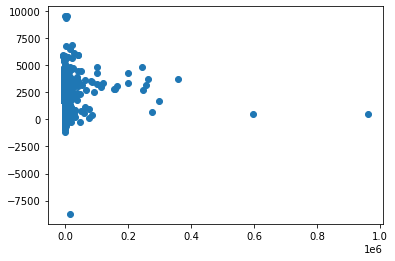

In [16]:
%matplotlib inline
residuals = y_test_linear_base - linear_base_pred
plt.scatter(residuals,linear_base_pred)

plt.show()

Apparently, our data does not present linear characteristics.

### 1.2 Standardized data

In [17]:
scaler = StandardScaler()
X_train_lm_std = pd.DataFrame(scaler.fit_transform(X_train_lm),columns=X_train_lm.columns)

In [18]:
scaler = StandardScaler()
X_test_lm_std = pd.DataFrame(scaler.fit_transform(X_test_lm),columns=X_test_lm.columns)

In [19]:
base_linear_std = sm.OLS(list(y_train_linear_base), sm.add_constant(X_train_lm_std))
base_linear_std_fitted = base_linear_std.fit()
print(base_linear_std_fitted.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     28.73
Date:                Fri, 25 Feb 2022   Prob (F-statistic):          1.82e-203
Time:                        04:05:32   Log-Likelihood:            -1.4701e+06
No. Observations:              142567   AIC:                         2.940e+06
Df Residuals:                  142528   BIC:                         2.941e+06
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  370.9572 

In [20]:
p_values_std = base_linear_std_fitted.summary2().tables[1]['P>|t|']

In [21]:
p_values_std[p_values_std<=0.001]

const                    2.023451e-82
Likes.at.Posting         2.096443e-15
Followers.at.Posting     6.573456e-28
Dic                      6.247618e-06
female                   1.041741e-04
male                     4.591618e-06
focusfuture              2.091243e-04
AllPunc                  8.884148e-05
Dash                     2.095295e-08
crosspost               2.089199e-109
Name: P>|t|, dtype: float64

In [22]:
p_values_std[p_values_std<=0.05]

const                    2.023451e-82
Likes.at.Posting         2.096443e-15
Followers.at.Posting     6.573456e-28
Dic                      6.247618e-06
ipron                    2.918997e-02
female                   1.041741e-04
male                     4.591618e-06
focuspresent             3.148311e-02
focusfuture              2.091243e-04
home                     1.817699e-02
AllPunc                  8.884148e-05
Dash                     2.095295e-08
link_title_len           9.496810e-03
crosspost               2.089199e-109
Name: P>|t|, dtype: float64

### 10 Fold Cross-Validate

In [23]:
cv = KFold(n_splits=10, random_state=1, shuffle=True)
model_std = LinearRegression()
scores_std = cross_val_score(model_std, X_train_lm_std, y_train_linear_base, scoring='neg_mean_absolute_error',
                         cv=cv, n_jobs=-1)
print("MAE:",np.mean(scores_std))

MAE: -587.7730392506992


In [24]:
linear_base_std_pred =  base_linear_std_fitted.predict(sm.add_constant(X_test_lm_std))
print_performance(y_test_linear_base, linear_base_std_pred)

Model Performance:
MSE: 31891556.482455976
MAE: 568.86808618599


# 2. Neural Network

Reference: 
- https://machinelearningmastery.com/regression-tutorial-keras-deep-learning-library-python/
- https://www.adriangb.com/scikeras/stable/index.html

In [25]:
# define base model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(38, input_dim=38, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

### Base Neural Network with standardized data

In [46]:
estimator_std = KerasRegressor(build_fn=baseline_model, epochs=100, batch_size=5, verbose=0)
kfold = KFold(n_splits=5)
results_std = cross_val_score(estimator_std,  X_train_lm_std, y_train_linear_base, cv=kfold)
print("Baseline: %.2f (%.2f) MSE" % (results_std.mean(), results_std.std()))

/opt/conda/lib/python3.7/site-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"
/opt/conda/lib/python3.7/site-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"
/opt/conda/lib/python3.7/site-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"
/opt/conda/lib/python3.7/site-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will rai

Baseline: 0.03 (0.02) MSE


In [27]:
estimator = KerasRegressor(build_fn=baseline_model, epochs=100, batch_size=5, verbose=False)
estimator.fit(X_train_lm_std, y_train_linear_base)
prediction_nn = estimator.predict(X_test_lm_std)
print_performance(y_test_linear_base, prediction_nn)

/opt/conda/lib/python3.7/site-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"
2022-02-25 04:13:59.099940: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-02-25 04:13:59.099982: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-02-25 04:13:59.100004: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (python-20220218-223849): /proc/driver/nvidia/version does not exist
2022-02-25 04:13:59.100404: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to u

Model Performance:
MSE: 31608893.548329707
MAE: 455.21078734893604


In [84]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(estimator, random_state=1).fit(X_train_lm_std, y_train_linear_base)
eli5.show_weights(perm, feature_names = X_train_lm_std.columns.tolist())

Weight,Feature
0.0163 ± 0.0013,Followers.at.Posting
0.0116 ± 0.0004,crosspost
0.0026 ± 0.0006,WC
0.0017 ± 0.0005,space
0.0015 ± 0.0007,see
0.0013 ± 0.0004,Message_len
0.0012 ± 0.0009,link_title_len
0.0011 ± 0.0001,ipron
0.0010 ± 0.0004,Live Video Complete
0.0009 ± 0.0004,focuspast


In [47]:
estimator.model_.save('saved_model.h5')

In [48]:
from keras.models import load_model

new_reg_model = load_model("saved_model.h5")
reg_new = KerasRegressor(new_reg_model)

reg_new.initialize(X_train_lm_std, y_train_linear_base)

KerasRegressor(
	model=<keras.engine.sequential.Sequential object at 0x7f270f430b90>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=None
	validation_batch_size=None
	verbose=1
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=1
)

In [49]:
prediction_test = reg_new.predict(X_test_lm_std)
print_performance(y_test_linear_base, prediction_test)

2195/2195 [==============================] - 2s 971us/step
Model Performance:
MSE: 31608893.5411224
MAE: 455.2107871706144


# 3. Ensemble Methods

## 3.1 Baseline: Random Forest 

In [58]:
forest_reg = RandomForestRegressor(random_state=1)
forest_model = forest_reg.fit(X_train_lm, y_train_linear_base)
forest_predicted = forest_model.predict(X_test_lm)
print_performance(forest_predicted, y_test_linear_base)

Model Performance:
MSE: 46443386.83208944
MAE: 519.804717393351


## 3.2 Gradient Boosting

In [59]:
from sklearn.ensemble import GradientBoostingRegressor
gbt_reg = GradientBoostingRegressor(random_state=1)
gbt_model = gbt_reg.fit(X_train_lm, y_train_linear_base)
gbt_predicted = gbt_model.predict(X_test_lm)
print_performance(gbt_predicted, y_test_linear_base)

Model Performance:
MSE: 37590585.01844021
MAE: 503.53495628119566


## 3.3 LightGBM

In [52]:
from lightgbm import LGBMRegressor
LGBM_reg = LGBMRegressor(random_state=1)
LGBM_model = LGBM_reg.fit(X_train_lm, y_train_linear_base)
LGBM_predicted = LGBM_model.predict(X_test_lm)
print_performance(LGBM_predicted, y_test_linear_base)

Model Performance:
MSE: 33859677.13579468
MAE: 557.3397242314782


## 3.4 XGBoost

In [56]:
from xgboost import XGBRegressor
xgb_reg = XGBRegressor()
xgb_model = xgb_reg.fit(X_train_lm, y_train_linear_base)
xgb_predicted = xgb_model.predict(X_test_lm)
print_performance(xgb_predicted, y_test_linear_base)

Model Performance:
MSE: 72761026.55609831
MAE: 536.4677360606779


## 3.5 Fine Tuning to see if prediction improves

Use random search to nail down fine tuning range with large scale of data

In [60]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs_rand = {
        'n_estimators': randint(low=1, high=8000),
        'max_features': randint(low=1, high=30),
    }

gb_reg = GradientBoostingRegressor(random_state=1)
rnd_search = RandomizedSearchCV(gb_reg, param_distributions=param_distribs_rand,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=1)
rnd_search.fit(X_train_lm, y_train_linear_base)

RandomizedSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=1),
                   param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f272d92d410>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f270f457b90>},
                   random_state=1, scoring='neg_mean_squared_error')

In [62]:
print(rnd_search.best_estimator_)
print(-rnd_search.best_score_)

GradientBoostingRegressor(max_features=1, n_estimators=145, random_state=1)
53179639.351380825


In [63]:
rand_opt_gbt = rnd_search.best_estimator_
rand_opt_predicted = rand_opt_gbt.predict(X_test_lm)
print_performance(rand_opt_predicted, y_test_linear_base)

Model Performance:
MSE: 32400354.10104623
MAE: 514.5306686666125


Fine tuning and compare its results to neural network

In [76]:
from sklearn.model_selection import GridSearchCV
gb_reg_fine = GradientBoostingRegressor(random_state=1)
param_grid = {
        'n_estimators': [50,100,200,300],
        'max_features': [1,5,10,15],
    }
grid_search = GridSearchCV(gb_reg_fine,param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
models_grid_search = grid_search.fit(X_train_lm, y_train_linear_base)

In [77]:
print(models_grid_search.best_estimator_)
print(-models_grid_search.best_score_)

GradientBoostingRegressor(max_features=1, random_state=1)
53097500.14307149


In [78]:
grid_opt_gbt = models_grid_search.best_estimator_
grid_opt_predicted = grid_opt_gbt.predict(X_test_lm)
print_performance(grid_opt_predicted, y_test_linear_base)

Model Performance:
MSE: 32320338.07785877
MAE: 501.7903840222031


It's performance is close to Neural Network performance

In [83]:
pd.DataFrame({"attribute":X_test_lm.columns,"importance":grid_opt_gbt.feature_importances_}).sort_values(by='importance', ascending=False).head(20)

,attribute,importance
28,AllPunc,0.304631
33,Message_sentiment,0.171203
37,crosspost,0.132782
4,you,0.105025
14,see,0.052229
0,Likes.at.Posting,0.045861
1,Followers.at.Posting,0.030685
26,home,0.023611
10,social,0.020899
22,focusfuture,0.020775
